In [1]:
%matplotlib inline

# Cargar una imagen con skimage

``` Python
from skimage import io
filename = os.path.join(skimage.data_dir, 'camera.png')
camera = io.imread(filename)
```

In [2]:
from skimage import io

pathMasc="C:\\Users\\Andres\\Desktop\\notebook\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9stmarcado.bmp"
pathImg="C:\\Users\\Andres\\Desktop\\notebook\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9storiginal.bmp"
pathCSV="C:\\Users\\Andres\\Desktop\\notebook\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9stlinea.csv"


img = io.imread(pathImg)
msc = io.imread(pathMasc)

# Visualizar imagen

 
```Python
import matplotlib.pyplot as plt
plt.figure() 
plt.imshow(img, cmap='gray') 
```

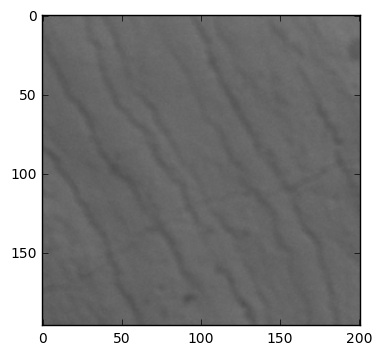

In [3]:
import matplotlib.pyplot as plt

plt.figure() 
plt.imshow(img, cmap='gray') 

# Acceder pixels individuales de una imagen

Simplemente como si fuese un array de dos dimensiones img[2, 3]

En pathCSV hay un csv con las coordenadas de los pixels por donde ha elegido el humano que se atraviesan los perikymata más claramente.

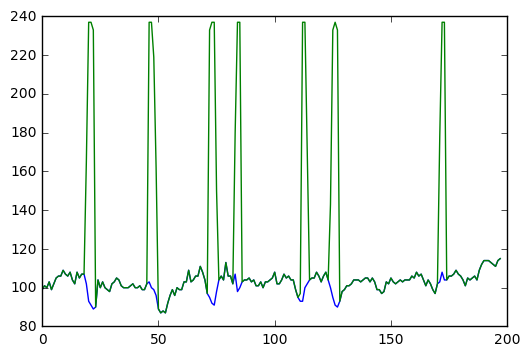

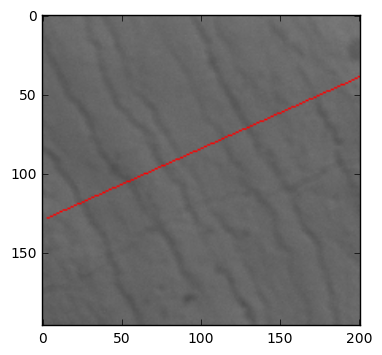

In [4]:
import csv

with open(pathCSV, newline='') as csvfile:
    perfiles = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    rows = []  # esto es una lista
    for row in perfiles:
        rows.append(row) 

imgProfile=img.copy()

# versión sencilla. Habría que sacar intensidad de profile y distancia al rojo en profileMsc
profile=[]
profileMsc=[]
for row in rows:
    profile.append(img[int(row[1]),int(row[0])][0])
    profileMsc.append(msc[int(row[1]),int(row[0])][0])
    imgProfile[int(row[1]),int(row[0])]=[255,0,0]

plt.plot(profile)
plt.plot(profileMsc)

plt.show()
               
plt.figure() 
plt.imshow(imgProfile, cmap='gray')                

## Adaptive Equalization

la ecualización del histograma de una imagen es una transformación que pretende obtener para una imagen un histograma con una distribución uniforme. 
Sirve para mejorar el contraste.

E:\Andres\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


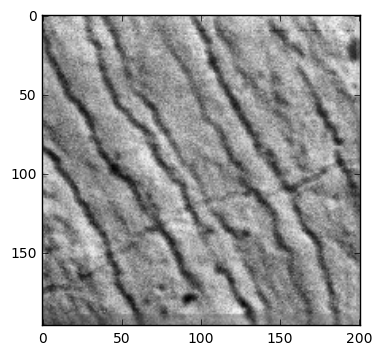

In [5]:
from skimage import exposure 
from skimage.color import rgb2grey

img=rgb2grey(img)

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

plt.figure() 
plt.imshow(img_adapteq, cmap='gray')  

Eliminación de ruido

E:\Andres\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


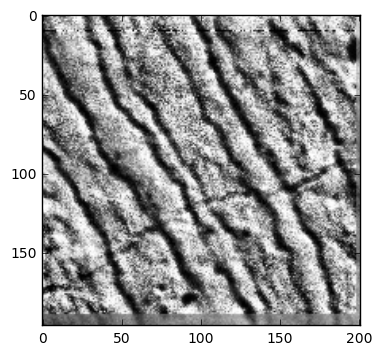

In [6]:
from skimage.restoration import denoise_tv_chambolle

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.91,nbins =100)
img_adapteq_deno=denoise_tv_chambolle(img_adapteq, weight=0.1)

plt.figure() 
plt.imshow(img_adapteq, cmap='gray')  

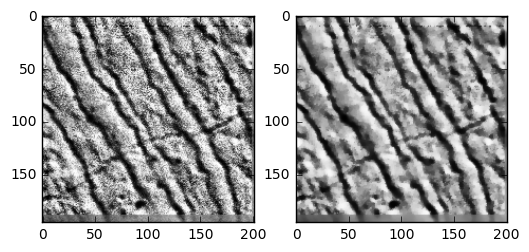

In [7]:


f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_adapteq, cmap='gray') 
axarr[1].imshow(img_adapteq_deno, cmap='gray') 

## Deteción de bordes

En concreto "The Frangi and hybrid Hessian filters can be used to detect continuous edges, such as vessels, wrinkles, and rivers", en nuestro caso los bordes son continuos así que se adapta a la perfección

### Primero la implementación que hizo Ismael


In [8]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import img_as_float

hxx, hxy, hyy = hessian_matrix(img_adapteq_deno, sigma=1.85,mode='wrap',cval=0.11)
i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy) # @UnusedVariable

edges = img_as_float(i1)


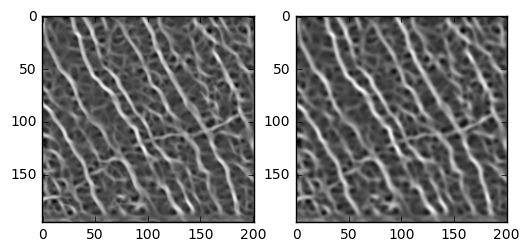

In [9]:
from scipy.ndimage import gaussian_filter

#eliminar ruido
filtered = gaussian_filter(edges, 1)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(edges, cmap='gray') 
axarr[1].imshow(filtered, cmap='gray') 

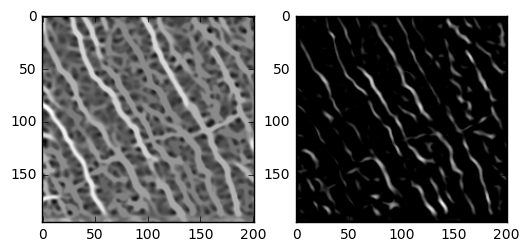

In [10]:
from skimage.morphology import reconstruction
import numpy as np 

seed = np.copy(filtered)
seed[1:-1, 1:-1] = filtered.min()
mask = filtered
dilated = reconstruction(seed, mask, method='dilation')
im=filtered - dilated

 


f, axarr = plt.subplots(1,2)
axarr[0].imshow(dilated, cmap='gray') 
axarr[1].imshow(im, cmap='gray') 

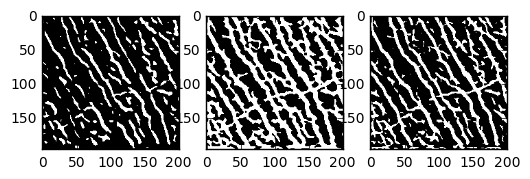

In [11]:
from skimage.filters import threshold_li

thresh1 = threshold_li(im)
thresh2 = threshold_li(dilated)
thresh3 = threshold_li(edges)

thresholded1 = im >= thresh1
thresholded2 = dilated >= thresh2
thresholded3 = edges >= thresh3

f, axarr = plt.subplots(1,3)
axarr[0].imshow(thresholded1, cmap='gray') #ismael
axarr[1].imshow(thresholded2, cmap='gray') 
axarr[2].imshow(thresholded3, cmap='gray') 

# Ismael hacia la binarización con el método de Li y la imagen im, pero parece que se ve mejor con edges directamente

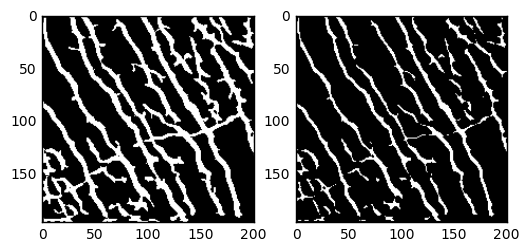

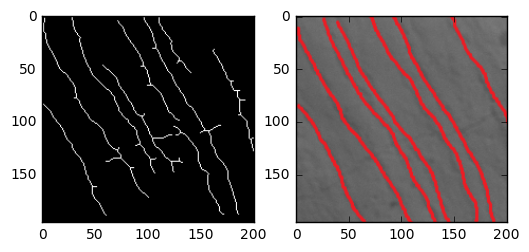

In [12]:
from skimage import morphology
from skimage.morphology import binary_erosion,diamond
from skimage.morphology import skeletonize

no_small = morphology.remove_small_objects(thresholded3, min_size=155,connectivity =100)
selem=diamond(1.9)
dil=binary_erosion(no_small, selem, out=None)
skl=skeletonize(dil)
no_small2 = morphology.remove_small_objects(skl, min_size=55,connectivity =100)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(no_small, cmap='gray') 
axarr[1].imshow(dil, cmap='gray') 

f, axarr = plt.subplots(1,2)
axarr[0].imshow(no_small2, cmap='gray') 
axarr[1].imshow(msc, cmap='gray') 

### Implementación que viene en los ejemplo.


En skimage hay un ejemplo http://scikit-image.org/docs/dev/auto_examples/filters/plot_frangi.html
De un método que está basado en la matriz hessiana.

Si lo pruebas no funciona porque no coinciden los fuentes de github con los que están en anaconda, debe ser un problema de versiones. 

Lo he solucionando copiando en \_frangi.py todas las funciones que no estaban en esta versión o recibian otros parámetros o estaban en otro lugar.



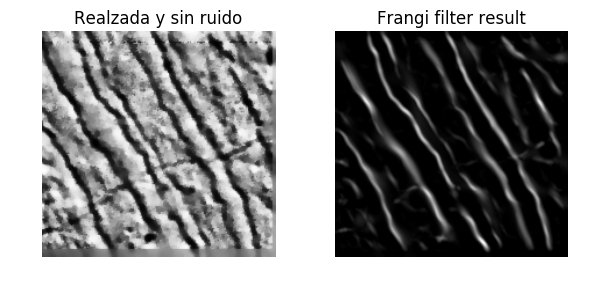

In [13]:
#from skimage.filters import frangi, hessian

from _frangi import frangi, hessian

image = img_adapteq_deno

fig, ax = plt.subplots(ncols=2, subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Realzada y sin ruido')
frangi = frangi(image)
ax[1].imshow(frangi, cmap=plt.cm.gray)
ax[1].set_title('Frangi filter result')


for a in ax:
    a.axis('off')

plt.tight_layout()

### Combinando ambas ideas

El detector de bordes de frangi se aplica a una imagen realzada y sin ruido y posteriormente se esqueletoniza y se eliminan objetos pequeños.

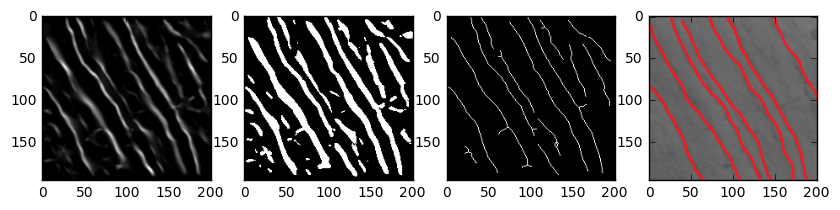

In [14]:
threshF = threshold_li(frangi)
thresholdedF = frangi >= threshF
skF=skeletonize(thresholdedF)
no_smallF = morphology.remove_small_objects(skF, min_size=20,connectivity =100)




f, axarr = plt.subplots(1,4,figsize=(10, 10))
axarr[0].imshow(frangi, cmap='gray') 
axarr[1].imshow(thresholdedF, cmap='gray') 
axarr[2].imshow(no_smallF, cmap='gray') 
axarr[3].imshow(msc, cmap='gray') 


## Uso de notebooks para probar interactivamente las funciones

Con Interact se puede ver el resultado de cambiar los parámetros de las funciones de manera muy rápida y cómoda. 
Se va a crear automáticamente un control con los tipos de datos que reciba la función

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

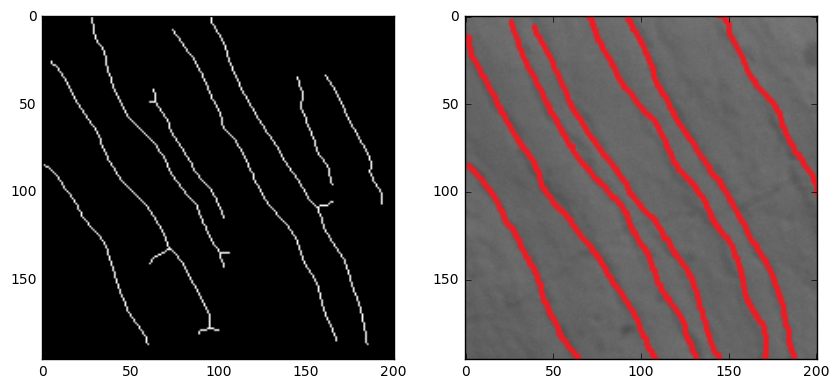

In [16]:

def f(x):
    no_small = morphology.remove_small_objects(skF, min_size=x,connectivity =100)
    f, axarr = plt.subplots(1,2,figsize=(10, 10))
    axarr[0].imshow(no_small, cmap='gray') 
    axarr[1].imshow(msc, cmap='gray') 

# AMT En 70 se ajusta mas al perfil de la máscara
interact(f, x=(10,100));

In [17]:
def f2(texto,numero,booleano):
    print(texto,numero,booleano)
    

interact(f2, texto=("Li","Otsu","Algoritmo 27"), numero = (1,10), booleano = True);

Li 5 True


## Evaluar como de buena es una propuesta

Por una parte habría que binarizar la imagen de la máscara, en el proyecto de Ismael hay un código para calcular la distancia a un determinado color. Si la distancia al rojo es menor de un determinado umbral ese pixel se pone a blanco y sino a negro.

Se obtienen los perfiles de ambas imágenes:
- mascara
- bordes

Esos perfiles serán 0,0,0,0,0,255,0,0,0,0,255, ... donde un 0 es el fondo y un 255 es un blanco que representa un perikymata


Una distancia que calcula el número de cambios para pasar de una secuencia a otra es la distancia de Levenshtein
https://es.wikipedia.org/wiki/Distancia_de_Levenshtein

Otra distancia que se podria probar es el https://en.wikipedia.org/wiki/Dynamic_time_warping



In [18]:
# from wiki. Pone str pero funciona con listas tb
def distance(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [19]:
distance("Hola","ola")

1

In [20]:
# pongo 0 no hay perikymata 1 si la hay
perfil1 = [0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0]
perfil2 = [0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0]
perfil3 = [0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0]
perfil4 = [0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0]

print(distance(perfil1,perfil2))
print(distance(perfil1,perfil3))
print(distance(perfil1,perfil4))

4
2
2


In [21]:
#Función para binarizar máscara marcando como blancos los rojos y negros el resto de colores.
#Threshold es el umbral para el color rojo, debería estar más o menos entre 180 y 255. 
#No hay que preocuparse en los valores del array R B G del azul y verde porque suponemos 
#que la máscara está en blanco y negro con las perikymata en rojo.
def binarizeRed(img,threshold):
    binarized = np.copy(img)
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j][0] > threshold:
                binarized[i][j] = [255, 255, 255]
            else: 
                binarized[i][j] = [0, 0, 0]
    return binarized



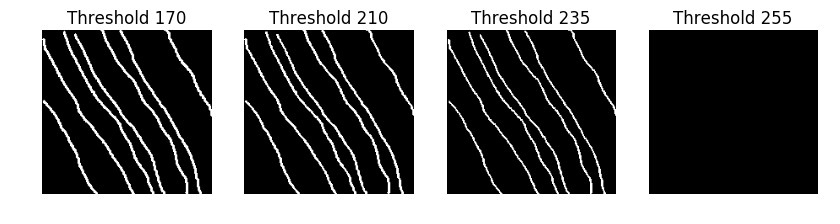

In [22]:

binMask1=binarizeRed(msc, 170)
binMask2=binarizeRed(msc, 210)
binMask3=binarizeRed(msc, 235)
binMask4=binarizeRed(msc, 255)

f, axes = plt.subplots(1,4,figsize=(10, 10))
axes[0].set_title("Threshold 170")
axes[1].set_title("Threshold 210")
axes[2].set_title("Threshold 235")
axes[3].set_title("Threshold 255")

for axe in axes:
    axe.axis('off')

axes[0].imshow(binMask1);
axes[1].imshow(binMask2);
axes[2].imshow(binMask3);
axes[3].imshow(binMask4);

In [38]:
# Esqueletonizar binarización de la máscara
skeletonize(binMask1)

ValueError: Skeletonize requires a 2D array